In [1]:

from default_parameters.lorenz63 import *
from ML_models.EchoStateNetwork import *
from essentials.create import create_ensemble
from essentials.DA import EnSRKF, EnKF, inflateEnsemble
from copy import deepcopy

In [20]:

observe_idx = np.array([0, 1, 2])  # Number of dimensions the ESN prediction
bayesian_update = True

update_reservoir = 1
plot_training_data = 0
plot_timeseries_flag = 1


In [21]:

ESN_params = bias_params.copy()
dt_ESN = dt_model * ESN_params['upsample']

dt_DA = .25 * t_lyap
total_time = 20. * t_lyap
num_DA_steps = int(total_time / dt_DA)

t_ref = t_lyap


N_train = int(ESN_params['t_train'] / dt_ESN)
N_val = int(ESN_params['t_val'] / dt_ESN)
N_test = int(ESN_params['t_test'] / dt_ESN) * 20



In [22]:

forecast_params['model'] = Lorenz63
forecast_params['dt'] = dt_model

truth = Lorenz63(**forecast_params)

Model dict_keys(['model']) not assigned


In [23]:
ESN_name = 'my_esn_partial'


train_model = create_ensemble(forecast_params, filter_params)
N_wtv_model = (N_train + N_val + ESN_params['N_wash'] * 2) * ESN_params['upsample']
N_test_model = N_test * ESN_params['upsample']
N_transient_model = int(train_model.t_transient / dt_model)
out = []
for Nt in [N_transient_model, N_wtv_model, N_test_model]:
    state, t1 = train_model.time_integrate(Nt)
    train_model.update_history(state, t1, reset=False)
    yy = train_model.get_observable_hist(Nt)
    out.append((yy, t1))
train_model.close()

rng = np.random.default_rng(0)


# Build training data dictionary
Y = train_model.get_observable_hist(N_wtv_model + N_test_model)
Y = Y.transpose(2, 0, 1)

# ESN class
ESN_case = EchoStateNetwork(Y[0, 0, :], dt=dt_model, **ESN_params)

# Train
ESN_train_data = dict(data=Y,
                      bayesian_update=bayesian_update,
                      observed_idx=observe_idx
                      )
ESN_case.train(**ESN_train_data)


Model dict_keys(['model']) not assigned

 ----------------- HYPERPARAMETER SEARCH ------------------
 5x5 grid and 15 points with Bayesian Optimization
		 rho	 sigma_in	 tikh	 MSE val 
1	 2.000e-01	 5.000e-01	 1.000e-12	 -1.1937
2	 2.000e-01	 1.581e+00	 1.000e-06	 -1.1648
3	 2.000e-01	 5.000e+00	 1.000e-06	 -1.3095
4	 2.000e-01	 1.581e+01	 1.000e-09	 -1.0732
5	 2.000e-01	 5.000e+01	 1.000e-06	 0.8400
6	 3.500e-01	 5.000e-01	 1.000e-09	 -1.0322
7	 3.500e-01	 1.581e+00	 1.000e-06	 -1.1011
8	 3.500e-01	 5.000e+00	 1.000e-06	 -1.2483
9	 3.500e-01	 1.581e+01	 1.000e-06	 -0.8344
10	 3.500e-01	 5.000e+01	 1.000e-06	 3.2918
11	 5.000e-01	 5.000e-01	 1.000e-12	 -1.0316
12	 5.000e-01	 1.581e+00	 1.000e-09	 -1.1494
13	 5.000e-01	 5.000e+00	 1.000e-06	 -1.2325
14	 5.000e-01	 1.581e+01	 1.000e-06	 1.3837
15	 5.000e-01	 5.000e+01	 1.000e-06	 3.4782
16	 6.500e-01	 5.000e-01	 1.000e-06	 -0.9982
17	 6.500e-01	 1.581e+00	 1.000e-09	 -1.1862
18	 6.500e-01	 5.000e+00	 1.000e-09	 -1.2093
19	 6.500e-01	 1.5

In [24]:

N_wash_model = ESN_case.N_wash * ESN_case.upsample
wash_model = ESN_train_data['data'][:, -N_wash_model:, ESN_case.observed_idx].transpose(1, 2, 0)

t_wash_model = np.arange(0, N_wash_model) * dt_model

wash_data, t_wash = wash_model[::ESN_case.upsample], t_wash_model[::ESN_case.upsample]
wash_data = wash_data[:, observe_idx]

u_wash, r_wash = ESN_case.openLoop(wash_data)


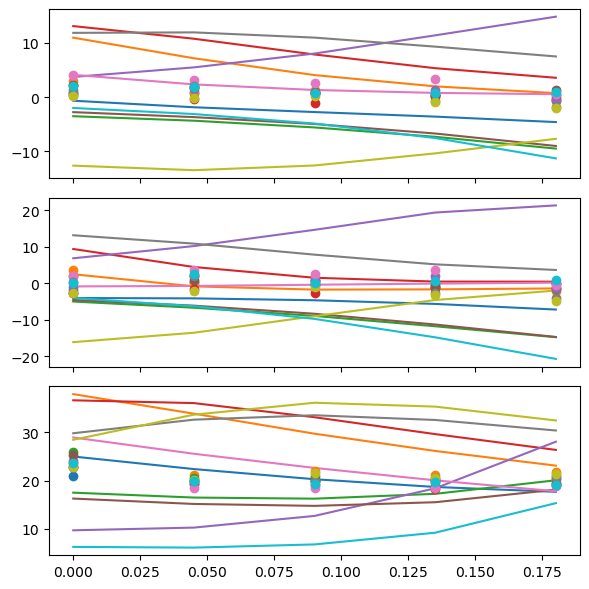

In [25]:
fig1 = plt.figure(figsize=(6, 6), layout="tight")
axs = fig1.subplots(nrows=ESN_case.N_dim, ncols=1, sharex='col', sharey='row')
for dim_i in range(ESN_case.N_dim):
    axs[dim_i].plot(t_wash, wash_data[:, dim_i, :])
    axs[dim_i].plot(t_wash, u_wash[:, dim_i, :], 'o')